In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy import units as u

from astropy.nddata import CCDData, StdDevUncertainty


from astropy import wcs
from astropy.io import fits
import sys

%matplotlib inline


GENERAL STRUCTURE:
---
- import file
- find mask of where data is
- find top/bottom edge of the mask + clip along x axis
- fit quadratics
- extract spec at a given line

INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


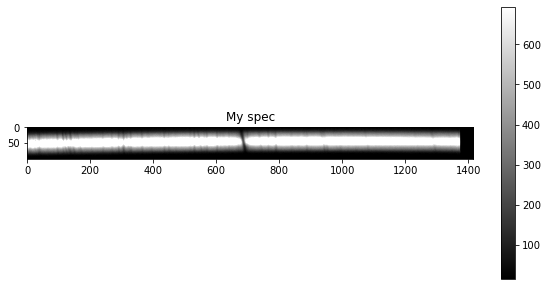

In [6]:
#Name of lambda calibrated 2D spectra image
sci = './saturn-2c-extr.fits'

#Display image spectrum 

sciimg = CCDData.read(sci, unit=u.adu)

def imshow(im, title_name='My spec'):
    # - - Shows 2D image with some additional info              - - #
    # - - Parameters: im -> ndarray; 2D image stored as ndarray - - #
    # - - Returns:    nothing                                   - - #

    plt.figure(figsize = (10, 5))
    plt.imshow(im, vmax = np.mean(im) + np.std(im), vmin = np.mean(im) - np.std(im), cmap = 'gray')
    plt.title(title_name)
    plt.colorbar()
    
imshow(sciimg)

SPECTRAL PROFILE - procedure stolen from the 2D-to-1D to calculate the mask

In [9]:
hdulist = fits.open(sci)


w = wcs.WCS(hdulist[1].header)


y_pixels,x_pixels = hdulist[1].data.shape

print(y_pixels,x_pixels)

#Create inital image matrix of all possible locations
pixcrd = np.array([[y , x] for y in range(y_pixels) for x in range(x_pixels)], dtype=np.float64)


# Convert pixel coordinates to world coordinates
# The second argument is "origin" -- in this case we're declaring we
# have 0-based (Numpy-like) coordinates.
# We convert all possible locations
world = w.wcs_pix2world(pixcrd, 0)


min_lambda = world[:,0].min()
max_lambda =world[:,0].max()

print('Lambda range is between ', min_lambda, ' and ', max_lambda)

#Decide on lambda increments to sum columns values
delta_lambda = (max_lambda - min_lambda )/ x_pixels

#Filter world coords to certain lambda range
lambda_map_to_pixel_group = {}
while min_lambda < max_lambda:
    pixels_at_lambda = np.where(np.logical_or(np.logical_and(world>=min_lambda, world< min_lambda+ delta_lambda),world> 0.01 ),  world, np.nan)
    lambda_map_to_pixel_group[min_lambda] = pixels_at_lambda[~np.isnan(pixels_at_lambda[:,0])]
    #print(pixels_at_lambda[~np.isnan(pixels_at_lambda[:,0])])
    
    min_lambda += delta_lambda
    
# Now go back to pixel coords and sum columns

signal_array = []
for wavelength in lambda_map_to_pixel_group.keys():
    if lambda_map_to_pixel_group[wavelength].shape[0] > 0:
        #print(wl, lambda_map_to_pixel_group[wl].shape)
        pixcrd2 = w.wcs_world2pix(lambda_map_to_pixel_group[wavelength], 0)
        #print(pixcrd2)
        signal = 0
        pixel_values_in_list = []
        for pixel in pixcrd2:
            pixel_value = hdulist[1].data[int(pixel[0])][int(pixel[1])]###change to change direction
            pixel_values_in_list.append(pixel_value)
            signal += pixel_value
        signal_array.append([wavelength, signal,pixel_values_in_list, len(pixel_values_in_list)] )


        
spectrum = pd.DataFrame(signal_array)

spectrum.rename({0:'Lambda', 1:'Signal', 2:'Actual Pixel Values',3:'Count Pixels' }, axis = 1, inplace=True)
spectrum.reset_index(inplace=True)
display(spectrum)


100 1417
Lambda range is between  6.48e-07  and  6.49188e-07


,index,Lambda,Signal,Actual Pixel Values,Count Pixels
0,0,6.480000e-07,16841.382274,"[9.992659002131058, 4.157909554400584, 17.0508...",1417
1,1,6.480117e-07,18978.115845,"[11.111373772546594, 14.958481736909876, 7.604...",1417
2,2,6.480235e-07,21398.069259,"[16.55621040897499, 1.3712428511674375, 15.105...",1417
3,3,6.480352e-07,25619.391535,"[17.578319008944085, -0.5895533134649722, 5.59...",1417
4,4,6.480478e-07,25619.391535,"[17.578319008944085, -0.5895533134649722, 5.59...",1417
...,...,...,...,...,...
95,95,6.491394e-07,8441.110876,"[12.588110030668863, 6.7676722922533035, 14.89...",1417
96,96,6.491519e-07,7675.440591,"[23.41277325102599, 0.8961464298584165, 20.841...",1417
97,97,6.491637e-07,7147.828772,"[21.954980783508177, -6.850592850369498, -3.19...",1417
98,98,6.491754e-07,7147.828772,"[21.954980783508177, -6.850592850369498, -3.19...",1417


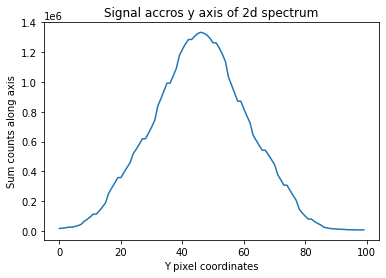

In [10]:
plt.plot(spectrum['index'], spectrum['Signal'])
plt.title('Signal accros y axis of 2d spectrum')
plt.xlabel('Y pixel coordinates')
plt.ylabel('Sum counts along axis')


plt.show()

MASK CALCULATION - FIND PIXELS WHERE 

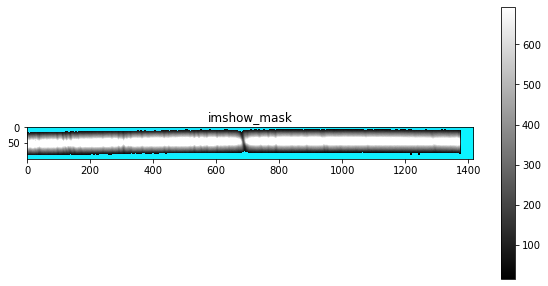

In [69]:
values = np.stack(spectrum['Actual Pixel Values'], axis=0)

masked = np.ma.masked_where(values > 100, sciimg)

def imshow_mask(im, msk, title='imshow_mask'):
    plt.figure(figsize = (10, 5))
    plt.imshow(im, vmax = np.mean(im) + np.std(im), vmin = np.mean(im) - np.std(im), cmap = 'gray')
    plt.colorbar()
    plt.imshow(msk, 'cool', alpha=1)
    plt.title(title)
    
    plt.show()

imshow_mask(sciimg,masked)

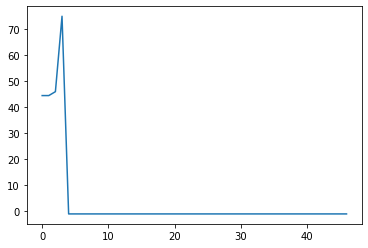

In [83]:
# These functions find the upper most and lower most pixel on a column which have visible singal 
# use value > 100 as a cutoff!
def first_signal(arr, axis=0, invalid_val=-1):
    mask = arr>100
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def last_signal(arr, axis=0, invalid_val=-1):
    mask = arr>100
    val = arr.shape[axis] - np.flip(mask, axis=axis).argmax(axis=axis) - 1
    return np.where(mask.any(axis=axis), val, invalid_val)

upper = first_signal(masked.data)
lower = last_signal(masked.data)
signal_coord = (upper + lower)/2

# plot to see where to clip along the x axis
plt.plot(signal_coord[1370:])


FIT A QUADRATIC to the signal coords and find plot on the image again

Fit value at x pixel coord 34 is 51.2406429885417


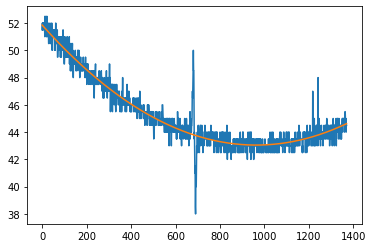

In [111]:
# clip data
y_coord = signal_coord[:1370]

x_coord = range(0,1370)

# fit the polynomial with built-in functions
fit = np.polyfit(x_coord, y_coord, 2)
# class that reproduce y-value if given x-value
polynomial = np.poly1d(fit)
# example
print('Fit value at x pixel coord 34 is {}'.format(polynomial(34)))
plt.plot(x_coord,y_coord,x_coord,polynomial(x_coord))

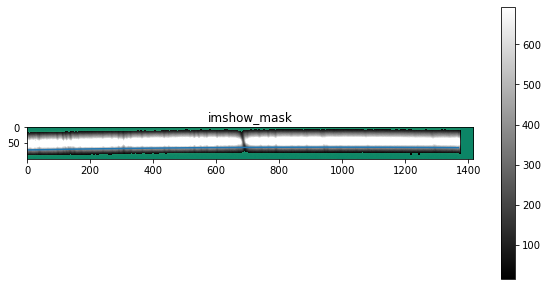

In [167]:
def imshow_mask(im, msk, title='imshow_mask'):
    plt.figure(figsize = (10, 5))
    plt.imshow(im, vmax = np.mean(im) + np.std(im), vmin = np.mean(im) - np.std(im), cmap = 'gray')
    plt.colorbar()
    plt.imshow(msk, 'summer', alpha=1)
    plt.plot(x_coord,polynomial(x_coord)+20)
    plt.title(title)
    
    plt.show()

imshow_mask(sciimg,masked)

In [112]:
y_pix_fitted = np.int16(polynomial(x_coord))
pixcrd_fit = np.array([[x , polynomial(x)] for x in x_coord], dtype=np.float64)

### EXTRACT VALUES

100 1417
6.48e-07 6.64428e-07


,Lambda,Signal,Actual Pixel Values,Count Pixels
0,6.480000e-07,268.406846,[268.40684613663814],1
1,6.480116e-07,308.201492,[308.20149180142874],1
2,6.480232e-07,286.480379,[286.4803793606214],1
3,6.480348e-07,233.532538,[233.53253843072508],1
4,6.480464e-07,233.532538,[233.53253843072508],1
...,...,...,...,...
1412,6.643700e-07,287.098994,[287.09899407144934],1
1413,6.643816e-07,287.098994,[287.09899407144934],1
1414,6.643932e-07,254.503147,[254.5031470149518],1
1415,6.644048e-07,233.508933,[233.50893308936503],1


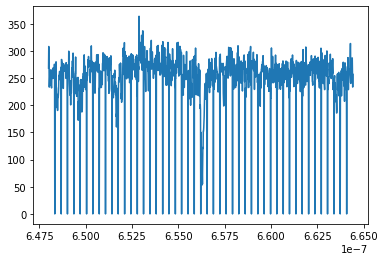

In [163]:
# Procedure to extract is the same as for the 2D-to-1D file, only the pixcrd
# goes to pixcrd_fit which is defined by the polynomial line

###From the images - decide if you want to cut on y direction
read_y_min, read_y_max = 0, y_pixels
#read_y_min = 20
#read_y_max = 40

hdulist = fits.open(sci)


w = wcs.WCS(hdulist[1].header)


y_pixels,x_pixels = hdulist[1].data.shape

print(y_pixels,x_pixels)
pixcrd_fit = np.array([[x , polynomial(x)+20] for x in x_coord], dtype=np.float64)

# Convert pixel coordinates to world coordinates
# The second argument is "origin" -- in this case we're declaring we
# have 0-based (Numpy-like) coordinates.

world = w.wcs_pix2world(pixcrd_fit, 0)
#print(world)
min_lambda = world[:,0].min()
max_lambda = world[:,0].max()
print(min_lambda,max_lambda)

delta_lambda = (max_lambda - min_lambda )/ x_pixels

lambda_map_to_pixel_group = {}
while min_lambda < max_lambda:
    pixels_at_lambda = np.where(np.logical_or(np.logical_and(world>=min_lambda, world< min_lambda+ delta_lambda),world> 0.01 ),  world, np.nan)
    lambda_map_to_pixel_group[min_lambda] = pixels_at_lambda[~np.isnan(pixels_at_lambda[:,0])]
    #print(pixels_at_lambda[~np.isnan(pixels_at_lambda[:,0])])
    
    min_lambda += delta_lambda
    
signal_array = []
for wl in lambda_map_to_pixel_group.keys():
    #print(wl, lambda_map_to_pixel_group[wl].shape)
    pixcrd2 = w.wcs_world2pix(lambda_map_to_pixel_group[wl], 0)
    #print(pixcrd2)
    signal = 0
    pixel_values_in_list = []
    for pixel in pixcrd2:
        if pixel[1] >= read_y_min and pixel[1] <read_y_max:
            pixel_value = hdulist[1].data[int(pixel[1])][int(pixel[0])]
            pixel_values_in_list.append(pixel_value)
            signal += pixel_value
    signal_array.append([wl, signal,pixel_values_in_list, len(pixel_values_in_list)] )


spectrum = pd.DataFrame(signal_array)

spectrum.rename({0:'Lambda', 1:'Signal', 2:'Actual Pixel Values',3:'Count Pixels' }, axis = 1, inplace=True)
# spectrum.drop(spectrum[spectrum.Signal <= 5000].index, inplace=True)
display(spectrum)
plt.plot(spectrum['Lambda'], spectrum['Signal'])
plt.show()

array([False, False, False, ..., False, False, False])

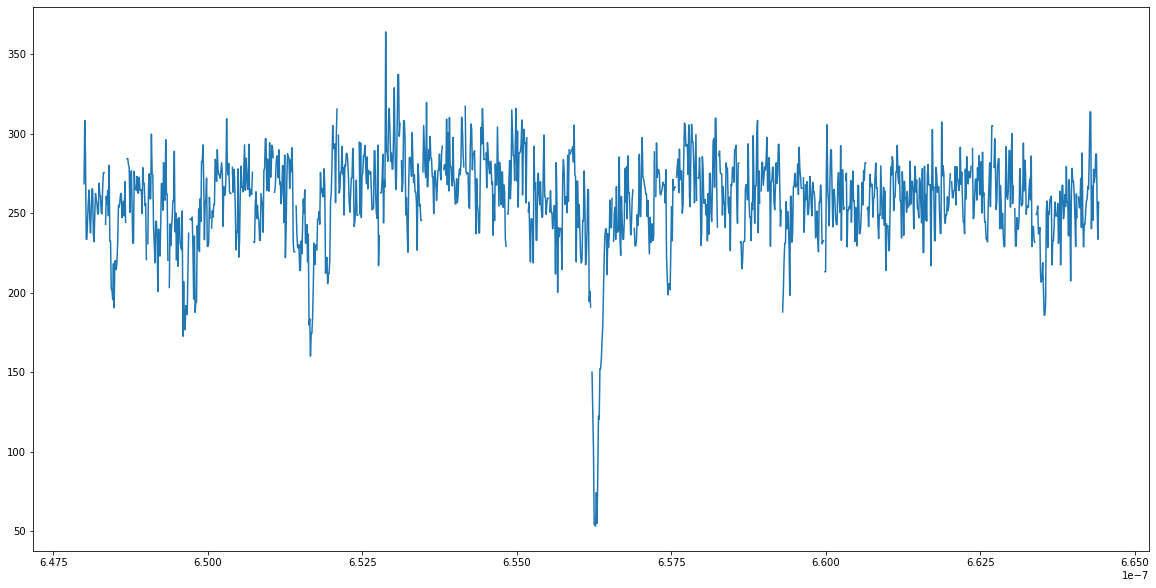

In [169]:
# mask to remove the non-sampled wavelengths
plt.figure(figsize=(20,10))
amaybe = spectrum['Signal']
mx = np.ma.masked_where(amaybe == 0, amaybe)
plt.plot(spectrum['Lambda'], mx)
# save an image to show the chat
plt.savefig('saturn-top-edge.png', dpi=400, transparent=False)

# attempt to smooth, not successful to combine with the mask yet
amaybe = spectrum['Signal']
mx = np.ma.masked_where(amaybe == 0, amaybe)
kernel_size = 3
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(mx, kernel, mode='same')
testmax = np.ma.getmask(mx)
final = np.ma.array(data_convolved, mask=testmax)
final.mask